In [1]:
import os
cwd = os.getcwd().replace("\\", "/")
print(cwd)

/kaggle/working


In [2]:
pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=d3e5e6177f37839c0e501871d60899e5260fabb1644fb2d505d71ce4a3d9d1d6
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=3bdf5a3a4054f2a7c6be1ee91a31ef96e392d4797e2920f176cc6a758f0b4d94
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import requests
import wandb
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import torch.nn.functional as F
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from glob import glob
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    RandomRotate90,
    ShiftScaleRotate,
    RandomBrightnessContrast,
    CLAHE,
    HueSaturationValue,
    GaussNoise,
    GridDistortion,
    Compose,
    RandomCrop
)
import cv2
from torch.utils.data import ConcatDataset, DataLoader

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
BATCH_SIZE = 2
workers = 0

kaggle = True if cwd == "/kaggle/working" else False
data_path = "/kaggle/input/" if kaggle else cwd + "/../../data/"

#takes path of x and returns x and y as images
def get_label(x_path):
    x_path = x_path.replace("\\", "/")

    if x_path.__contains__("ethz") or x_path.__contains__("suburbs"):
        y_path = x_path.replace("images/", "groundtruth/")

    if x_path.__contains__("roadsegmentation"):
        y_path = x_path.replace("images/", "groundtruth/").replace(".jpg", ".png")

    return Image.open(x_path), Image.open(y_path)


def save(model, optim, name):
    path = ("/kaggle/working/" if kaggle else "") + name + ".pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
    }, path)

def load(model, optim, name):
    path = ("/kaggle/working/" if kaggle else "") + name + ".pth"
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optim.load_state_dict(checkpoint['optimizer_state_dict'])


In [5]:
model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
feature_extractor:SegformerImageProcessor = SegformerImageProcessor.from_pretrained(model_name, size=400)

/opt/conda/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
def get_geometric_transforms_official():
    geometric_transforms = [
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
    ]
    return Compose(geometric_transforms, additional_targets={'mask':'image'})


def get_photometric_transforms():
    return None
    photometric_transforms = [
        RandomBrightnessContrast(p=0.5),
        CLAHE(p=0.5),
        HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        GaussNoise(p=0.5)
    ]
    return Compose(photometric_transforms)


return_orig_images = False
class CustomDataset(Dataset):
    def __init__(self, image_files, geometric_transform=None, photometric_transform=None):
        self.image_files = image_files
        self.geometric_transform = geometric_transform
        self.photometric_transform = photometric_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        x_orig, y_orig = get_label(self.image_files[idx])

        x_orig:Image = x_orig.convert("RGB")
        y_orig:Image = y_orig.convert("RGB")
        
        x_orig_np = np.array(x_orig, dtype=np.uint8)
        y_orig_np = np.array(y_orig, dtype=np.uint8)

        # Apply geometric transforms
        x_augmented, y_augmented = x_orig_np.copy(), y_orig_np.copy()
        if self.geometric_transform:
            augmented = self.geometric_transform(image=x_augmented.copy(), mask=y_augmented.copy())
            x_augmented, y_augmented = augmented['image'], augmented['mask']

        # Apply photometric transforms
        if self.photometric_transform:
            augmented = self.photometric_transform(image=x_augmented.copy())
            x_augmented = augmented['image']

        x = feature_extractor(images=x_augmented.astype(np.float32), return_tensors="pt").pixel_values.squeeze(0).cuda()
        y = torch.tensor((y_augmented.astype(np.float32)/255)[:, :, 0], dtype=torch.float32).unsqueeze(0).cuda()

        if return_orig_images:

            # Convert the images to float32
            x_orig_np = x_orig_np.astype(np.float32) / 255
            y_orig_np = y_orig_np.astype(np.float32) / 255
            x_augmented = x_augmented.astype(np.float32) / 255
            y_augmented = y_augmented.astype(np.float32) / 255



            return x, y, self.image_files[idx], x_orig_np, y_orig_np, x_augmented, y_augmented
        
        else:
            return x, y, self.image_files[idx], torch.zeros(1), torch.zeros(1), torch.zeros(1), torch.zeros(1)

In [8]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 1
ACTIVATION = 'sigmoid' 

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=CLASSES, 
    activation=ACTIVATION,
).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 67.6MB/s]


In [9]:
googlemaps_dataset = CustomDataset(glob(data_path + "googlemaps-boston-losangeles-suburbs/images/*.png"), get_geometric_transforms_official(), get_photometric_transforms())
googlemaps_loader = DataLoader(googlemaps_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=workers)

In [10]:
main_dataset_len = len(glob(data_path + "ethz-cil-road-segmentation-2023/training/images/*.png"))

# Split the dataset
val_size = int(main_dataset_len * 0.2)
train_size = main_dataset_len - val_size
torch.manual_seed(0)
indices = torch.randperm(main_dataset_len).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Apply transformations only on training set
train_dataset = CustomDataset(np.array(glob(data_path + "ethz-cil-road-segmentation-2023/training/images/*.png"))[train_indices], None, None)
train_dataset_augmented = CustomDataset(np.array(glob(data_path + "ethz-cil-road-segmentation-2023/training/images/*.png"))[train_indices], get_geometric_transforms_official(), get_photometric_transforms())
val_dataset = CustomDataset(np.array(glob(data_path + "ethz-cil-road-segmentation-2023/training/images/*.png"))[val_indices], None, None)
val_dataset_augmented = CustomDataset(np.array(glob(data_path + "ethz-cil-road-segmentation-2023/training/images/*.png"))[val_indices], get_geometric_transforms_official(), get_photometric_transforms())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=workers)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=workers)
val_loader_augmented = DataLoader(val_dataset_augmented, batch_size=BATCH_SIZE, shuffle=False, num_workers=workers)

In [11]:
def visualize_sample(model, loader, rows=4):
    model.eval()
    global return_orig_images
    return_orig_images = True
    with torch.no_grad():
        fig, ax = plt.subplots(rows, 5, figsize=(40, 40))
        for i, (x, y, name, x_orig, y_orig, x_augmented, y_augmented) in enumerate(loader):
            x = x[0]
            y = y[0]
            name = name[0]
            x_orig = x_orig[0]
            y_orig = y_orig[0]
            x_augmented = x_augmented[0]
            y_augmented = y_augmented[0]

            pred = model(x.unsqueeze(0)).squeeze(0)

            pred = F.sigmoid(pred).permute(1, 2, 0).cpu().numpy()
            y = y.permute(1, 2, 0).cpu().numpy()
            x = x.permute(1, 2, 0).cpu().numpy()

            ax[i][0].imshow(x_orig)
            ax[i][1].imshow(y_orig)
            ax[i][2].imshow(x_augmented)
            ax[i][3].imshow(y_augmented)
            ax[i][4].imshow(pred, cmap='gray')
            

            if i == rows - 1:
                break
            
    return_orig_images = False

In [12]:
# visualize_sample(model, train_loader)

In [13]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

In [14]:
use_wandb = False

def train(model, dataset, optimizer):
    model.train()
    total_loss = 0
    steps = 0
    for x, y, _a, _b, _c, _d, _e in tqdm(dataset):
        x, y = x.cuda(), y.cuda()     
        optimizer.zero_grad()
        # print(x.shape)
        y_pred = model(x)
        # y_pred = torch.repeat_interleave(torch.repeat_interleave(y_pred, 2, dim=2), 2, dim=3)
        # y_pred = torch.repeat_interleave(torch.repeat_interleave(y_pred, 2, dim=2), 2, dim=3)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        steps += 1
        
        if steps % 100 == 0:
            print("Training Loss:", total_loss / steps)
            if use_wandb: wandb.log({"Train Loss": total_loss / steps})
            

    print("Training Loss:", total_loss / len(dataset))
    if use_wandb: wandb.log({"Train Loss": total_loss / len(dataset)})

In [15]:
def validate(model, dataset):
    model.eval()
    y_preds = np.array([], dtype=np.float32)
    y_gt = np.array([], dtype=np.float32)
    with torch.no_grad():
        for x, y, _a, _b, _c, _d, _e in dataset:
            x, y = x.cuda(), y.cuda()  
            y_pred = model(x)
            y_pred = torch.sigmoid(y_pred)

            # apply pooling to reduce the prediction from 400x400 to 25x25
            y_pred = F.avg_pool2d(y_pred, 16, stride=16)
            # apply pooling to reduce the label from 400x400 to 25x25
            y = F.avg_pool2d(y, 16, stride=16)

            y_preds = np.concatenate((y_preds, y_pred.cpu().numpy().flatten()))
            y_gt = np.concatenate((y_gt, y.cpu().numpy().flatten()))
            
            
    y_preds = np.array(y_preds)
    y_gt = np.array(y_gt)
    for tresh in np.arange(0.15,0.40,0.05):        
        score = f1_score(y_gt>0.25, y_preds > tresh)
        print("Validation F1 Score for tresh",tresh,":", score)
        if use_wandb: wandb.log("Validation F1 Score for tresh "+str(tresh) +": " + str(score))

In [16]:
combined_official_dataset = ConcatDataset([train_dataset, val_dataset])
combined_official_loader = DataLoader(combined_official_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=workers)

combined_official_google_dataset = ConcatDataset([train_dataset_augmented, googlemaps_dataset])
combined_official_google_loader = DataLoader(combined_official_google_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=workers)


actual_pretrain_loader = googlemaps_loader

actual_train_loader = combined_official_google_loader

actual_val_loader = val_loader

In [17]:
#train the classification head and the last block
for param in model.parameters():
    param.requires_grad = False
for param in model.segmentation_head.parameters():
    param.requires_grad = True
for param in model.encoder.layer4.parameters():
    param.requires_grad = True


print("trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

for epoch in range(2):
    train(model, actual_pretrain_loader, optimizer)
    validate(model, actual_val_loader)

trainable parameters: 14964993


 13%|█▎        | 101/780 [00:27<02:40,  4.24it/s]

Training Loss: 0.8503396338224412


 26%|██▌       | 200/780 [00:47<02:28,  3.89it/s]

Training Loss: 0.8093353554606437


 39%|███▊      | 301/780 [01:08<01:31,  5.26it/s]

Training Loss: 0.7842906868457794


 51%|█████▏    | 401/780 [01:28<01:13,  5.18it/s]

Training Loss: 0.7675270995497704


 64%|██████▍   | 501/780 [01:50<00:57,  4.86it/s]

Training Loss: 0.7557700111865997


 77%|███████▋  | 600/780 [02:11<00:32,  5.48it/s]

Training Loss: 0.7469359274705251


 90%|████████▉ | 701/780 [02:33<00:14,  5.48it/s]

Training Loss: 0.740147408076695


100%|██████████| 780/780 [02:49<00:00,  4.59it/s]


Training Loss: 0.7356294946028636
Validation F1 Score for tresh 0.15 : 0.3736815203754473
Validation F1 Score for tresh 0.2 : 0.3736815203754473
Validation F1 Score for tresh 0.25 : 0.3736815203754473
Validation F1 Score for tresh 0.30000000000000004 : 0.3736815203754473
Validation F1 Score for tresh 0.3500000000000001 : 0.3736815203754473


 13%|█▎        | 101/780 [00:10<01:13,  9.20it/s]

Training Loss: 0.6949043130874634


 26%|██▌       | 201/780 [00:21<01:08,  8.47it/s]

Training Loss: 0.6939811810851098


 39%|███▊      | 301/780 [00:32<00:51,  9.27it/s]

Training Loss: 0.6931822552283605


 51%|█████▏    | 401/780 [00:43<00:40,  9.27it/s]

Training Loss: 0.6926316952705384


 64%|██████▍   | 501/780 [00:54<00:29,  9.36it/s]

Training Loss: 0.6918669248819351


 77%|███████▋  | 601/780 [01:05<00:18,  9.55it/s]

Training Loss: 0.6912594858805339


 90%|████████▉ | 701/780 [01:16<00:08,  9.35it/s]

Training Loss: 0.690571152312415


100%|██████████| 780/780 [01:24<00:00,  9.18it/s]


Training Loss: 0.6900881988879962
Validation F1 Score for tresh 0.15 : 0.3736815203754473
Validation F1 Score for tresh 0.2 : 0.3736815203754473
Validation F1 Score for tresh 0.25 : 0.3736815203754473
Validation F1 Score for tresh 0.30000000000000004 : 0.3736815203754473
Validation F1 Score for tresh 0.3500000000000001 : 0.3736815203754473


In [23]:
# model.encoder

In [18]:
module_encoder_first = nn.ModuleList([model.encoder.conv1, model.encoder.bn1, model.encoder.relu, model.encoder.maxpool])

In [19]:
#train everything except for the start of the encoder
for param in model.parameters():
    param.requires_grad = True
for param in module_encoder_first.parameters():
    param.requires_grad = False
# for param in model.segformer.encoder.block[0].parameters():
#     param.requires_grad = False

print("trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

trainable parameters: 26668049


In [20]:
#do a warmup epoch for the new optimizer
optimizer.param_groups[0]['lr'] = 1e-9
for epoch in range(1):
    train(model, actual_pretrain_loader, optimizer)
    validate(model, actual_val_loader)

save(model, optimizer, "deeplab_post_warmup")

# visualize_sample(model, googlemaps_loader)
# visualize_sample(model, val_loader)
optimizer.param_groups[0]['lr'] = 1e-4

 13%|█▎        | 101/780 [00:14<01:32,  7.31it/s]

Training Loss: 0.685065952539444


 26%|██▌       | 201/780 [00:27<01:19,  7.25it/s]

Training Loss: 0.6854357182979584


 39%|███▊      | 301/780 [00:42<01:06,  7.15it/s]

Training Loss: 0.6848976200819016


 51%|█████▏    | 401/780 [00:55<00:52,  7.26it/s]

Training Loss: 0.6850316175818443


 64%|██████▍   | 501/780 [01:09<00:38,  7.29it/s]

Training Loss: 0.6849139947891235


 77%|███████▋  | 601/780 [01:23<00:24,  7.26it/s]

Training Loss: 0.6848625561594963


 90%|████████▉ | 701/780 [01:37<00:12,  6.42it/s]

Training Loss: 0.6848268742220742


100%|██████████| 780/780 [01:48<00:00,  7.19it/s]


Training Loss: 0.6850292461040692
Validation F1 Score for tresh 0.15 : 0.3736815203754473
Validation F1 Score for tresh 0.2 : 0.3736815203754473
Validation F1 Score for tresh 0.25 : 0.3736815203754473
Validation F1 Score for tresh 0.30000000000000004 : 0.3736815203754473
Validation F1 Score for tresh 0.3500000000000001 : 0.3736815203754473


In [21]:
for epoch in range(6):
    train(model, actual_train_loader, optimizer)
    validate(model, actual_val_loader)
    save(model, optimizer, "deeplab_e-4")



# visualize_sample(model, actual_val_loader)

 12%|█▏        | 101/838 [00:14<01:45,  6.96it/s]

Training Loss: 0.6819273918867111


 24%|██▍       | 201/838 [00:29<01:27,  7.32it/s]

Training Loss: 0.6798382821679115


 36%|███▌      | 301/838 [00:43<01:14,  7.22it/s]

Training Loss: 0.6777383859952291


 48%|████▊     | 401/838 [00:57<01:01,  7.09it/s]

Training Loss: 0.6767327304184437


 60%|█████▉    | 501/838 [01:11<00:44,  7.51it/s]

Training Loss: 0.6752839595079422


 72%|███████▏  | 601/838 [01:26<00:33,  7.04it/s]

Training Loss: 0.6744629926482837


 84%|████████▎ | 701/838 [01:40<00:19,  7.13it/s]

Training Loss: 0.6738328407491957


 96%|█████████▌| 801/838 [01:55<00:06,  6.08it/s]

Training Loss: 0.6731978160142899


100%|██████████| 838/838 [02:00<00:00,  6.93it/s]


Training Loss: 0.6731261394046656
Validation F1 Score for tresh 0.15 : 0.3736815203754473
Validation F1 Score for tresh 0.2 : 0.3736815203754473
Validation F1 Score for tresh 0.25 : 0.3736815203754473
Validation F1 Score for tresh 0.30000000000000004 : 0.3736815203754473
Validation F1 Score for tresh 0.3500000000000001 : 0.3736815203754473


 12%|█▏        | 101/838 [00:14<01:39,  7.41it/s]

Training Loss: 0.6669467628002167


 24%|██▍       | 201/838 [00:28<01:27,  7.28it/s]

Training Loss: 0.6672710737586022


 36%|███▌      | 301/838 [00:41<01:15,  7.08it/s]

Training Loss: 0.6674855252106985


 48%|████▊     | 401/838 [00:56<01:09,  6.30it/s]

Training Loss: 0.6672817274928093


 60%|█████▉    | 501/838 [01:09<00:46,  7.32it/s]

Training Loss: 0.6672091240882874


 72%|███████▏  | 601/838 [01:23<00:32,  7.39it/s]

Training Loss: 0.6669688573479653


 84%|████████▎ | 701/838 [01:37<00:18,  7.30it/s]

Training Loss: 0.666793669462204


 96%|█████████▌| 801/838 [01:51<00:05,  7.15it/s]

Training Loss: 0.6669999276101589


100%|██████████| 838/838 [01:56<00:00,  7.18it/s]


Training Loss: 0.6670036261861251
Validation F1 Score for tresh 0.15 : 0.3736815203754473
Validation F1 Score for tresh 0.2 : 0.3736815203754473
Validation F1 Score for tresh 0.25 : 0.3736815203754473
Validation F1 Score for tresh 0.30000000000000004 : 0.3736815203754473
Validation F1 Score for tresh 0.3500000000000001 : 0.3736815203754473


 12%|█▏        | 101/838 [00:14<01:43,  7.14it/s]

Training Loss: 0.6625176674127579


 24%|██▍       | 201/838 [00:28<01:28,  7.16it/s]

Training Loss: 0.6643246534466744


 36%|███▌      | 301/838 [00:42<01:14,  7.17it/s]

Training Loss: 0.664536080956459


 48%|████▊     | 401/838 [00:56<01:00,  7.26it/s]

Training Loss: 0.6647821627557278


 60%|█████▉    | 501/838 [01:10<00:46,  7.25it/s]

Training Loss: 0.6647062726020813


 72%|███████▏  | 601/838 [01:24<00:33,  7.16it/s]

Training Loss: 0.6645329534014066


 84%|████████▎ | 701/838 [01:38<00:19,  6.87it/s]

Training Loss: 0.6646628628458295


 96%|█████████▌| 801/838 [01:52<00:05,  7.39it/s]

Training Loss: 0.6645661939680576


100%|██████████| 838/838 [01:57<00:00,  7.15it/s]


Training Loss: 0.664560146860974
Validation F1 Score for tresh 0.15 : 0.3736815203754473
Validation F1 Score for tresh 0.2 : 0.3736815203754473
Validation F1 Score for tresh 0.25 : 0.3736815203754473
Validation F1 Score for tresh 0.30000000000000004 : 0.3736815203754473
Validation F1 Score for tresh 0.3500000000000001 : 0.3736815203754473


 12%|█▏        | 101/838 [00:14<01:49,  6.73it/s]

Training Loss: 0.6629178321361542


 24%|██▍       | 201/838 [00:28<01:29,  7.11it/s]

Training Loss: 0.663242244720459


 36%|███▌      | 301/838 [00:42<01:24,  6.37it/s]

Training Loss: 0.6633715564012528


 48%|████▊     | 401/838 [00:56<01:01,  7.16it/s]

Training Loss: 0.6636669202148915


 60%|█████▉    | 501/838 [01:10<00:46,  7.26it/s]

Training Loss: 0.6636164580583572


 72%|███████▏  | 601/838 [01:24<00:33,  7.04it/s]

Training Loss: 0.6634840282797814


 84%|████████▎ | 701/838 [01:38<00:19,  7.14it/s]

Training Loss: 0.6633502351386207


 96%|█████████▌| 801/838 [01:52<00:05,  7.25it/s]

Training Loss: 0.6631398636102677


100%|██████████| 838/838 [01:57<00:00,  7.11it/s]


Training Loss: 0.6631096691817827
Validation F1 Score for tresh 0.15 : 0.3736815203754473
Validation F1 Score for tresh 0.2 : 0.3736815203754473
Validation F1 Score for tresh 0.25 : 0.3736815203754473
Validation F1 Score for tresh 0.30000000000000004 : 0.3736815203754473
Validation F1 Score for tresh 0.3500000000000001 : 0.3736815203754473


 12%|█▏        | 101/838 [00:14<01:43,  7.12it/s]

Training Loss: 0.6607966047525405


 24%|██▍       | 201/838 [00:28<01:30,  7.06it/s]

Training Loss: 0.6610648894309997


 36%|███▌      | 301/838 [00:42<01:12,  7.37it/s]

Training Loss: 0.6612949319680532


 48%|████▊     | 401/838 [00:56<00:58,  7.41it/s]

Training Loss: 0.6617557308077813


 60%|█████▉    | 501/838 [01:10<00:46,  7.23it/s]

Training Loss: 0.6615454610586167


 72%|███████▏  | 601/838 [01:24<00:32,  7.19it/s]

Training Loss: 0.6618983595569928


 84%|████████▎ | 701/838 [01:37<00:18,  7.41it/s]

Training Loss: 0.6620108377082007


 96%|█████████▌| 801/838 [01:51<00:05,  7.15it/s]

Training Loss: 0.6622567761689424


100%|██████████| 838/838 [01:57<00:00,  7.15it/s]


Training Loss: 0.6621940970989856
Validation F1 Score for tresh 0.15 : 0.3736815203754473
Validation F1 Score for tresh 0.2 : 0.3736815203754473
Validation F1 Score for tresh 0.25 : 0.3736815203754473
Validation F1 Score for tresh 0.30000000000000004 : 0.3736815203754473
Validation F1 Score for tresh 0.3500000000000001 : 0.3736815203754473


 12%|█▏        | 101/838 [00:14<01:42,  7.17it/s]

Training Loss: 0.6588149899244309


 24%|██▍       | 201/838 [00:28<01:32,  6.88it/s]

Training Loss: 0.6597849333286285


 36%|███▌      | 301/838 [00:42<01:16,  7.02it/s]

Training Loss: 0.6615639501810073


 48%|████▊     | 401/838 [00:56<01:02,  7.01it/s]

Training Loss: 0.662080115377903


 60%|█████▉    | 501/838 [01:10<00:45,  7.37it/s]

Training Loss: 0.6614377399682999


 72%|███████▏  | 601/838 [01:24<00:33,  7.17it/s]

Training Loss: 0.6615063633521397


 84%|████████▎ | 701/838 [01:38<00:18,  7.27it/s]

Training Loss: 0.6614019456080028


 96%|█████████▌| 801/838 [01:52<00:05,  7.38it/s]

Training Loss: 0.6615250184386968


100%|██████████| 838/838 [01:57<00:00,  7.15it/s]


Training Loss: 0.661525199051973
Validation F1 Score for tresh 0.15 : 0.3736815203754473
Validation F1 Score for tresh 0.2 : 0.3736815203754473
Validation F1 Score for tresh 0.25 : 0.3736815203754473
Validation F1 Score for tresh 0.30000000000000004 : 0.3736815203754473
Validation F1 Score for tresh 0.3500000000000001 : 0.3736815203754473


In [22]:
optimizer.param_groups[0]['lr'] = 1e-5

for epoch in range(2):
    train(model, actual_train_loader, optimizer)
    validate(model, actual_val_loader)

save(model, optimizer, "deeplab_e-5")

 12%|█▏        | 101/838 [00:14<01:41,  7.23it/s]

Training Loss: 0.659923010468483


 24%|██▍       | 201/838 [00:28<01:26,  7.38it/s]

Training Loss: 0.6596229961514473


 36%|███▌      | 301/838 [00:42<01:12,  7.39it/s]

Training Loss: 0.6598177134990693


 48%|████▊     | 401/838 [00:56<01:05,  6.66it/s]

Training Loss: 0.6596949176490307


 60%|█████▉    | 501/838 [01:10<00:46,  7.23it/s]

Training Loss: 0.6592897554636001


 72%|███████▏  | 601/838 [01:24<00:32,  7.31it/s]

Training Loss: 0.6589311171571414


 84%|████████▎ | 701/838 [01:38<00:18,  7.24it/s]

Training Loss: 0.6590668720006942


 96%|█████████▌| 801/838 [01:52<00:05,  7.26it/s]

Training Loss: 0.6593749621510505


100%|██████████| 838/838 [01:57<00:00,  7.15it/s]


Training Loss: 0.6593697581769173
Validation F1 Score for tresh 0.15 : 0.3736815203754473
Validation F1 Score for tresh 0.2 : 0.3736815203754473
Validation F1 Score for tresh 0.25 : 0.3736815203754473
Validation F1 Score for tresh 0.30000000000000004 : 0.3736815203754473
Validation F1 Score for tresh 0.3500000000000001 : 0.3736815203754473


 12%|█▏        | 101/838 [00:14<01:52,  6.57it/s]

Training Loss: 0.6590275067090988


 24%|██▍       | 201/838 [00:28<01:29,  7.14it/s]

Training Loss: 0.657868883907795


 36%|███▌      | 301/838 [00:42<01:15,  7.10it/s]

Training Loss: 0.658124920129776


 48%|████▊     | 401/838 [00:56<01:00,  7.24it/s]

Training Loss: 0.6586481201648712


 60%|█████▉    | 501/838 [01:10<00:47,  7.09it/s]

Training Loss: 0.6587538747787476


 72%|███████▏  | 601/838 [01:24<00:32,  7.19it/s]

Training Loss: 0.6588485463460286


 84%|████████▎ | 701/838 [01:38<00:18,  7.22it/s]

Training Loss: 0.658583186864853


 96%|█████████▌| 801/838 [01:52<00:05,  7.17it/s]

Training Loss: 0.6583154023438692


100%|██████████| 838/838 [01:57<00:00,  7.15it/s]


Training Loss: 0.6584039912303479
Validation F1 Score for tresh 0.15 : 0.3736815203754473
Validation F1 Score for tresh 0.2 : 0.3736815203754473
Validation F1 Score for tresh 0.25 : 0.3736815203754473
Validation F1 Score for tresh 0.30000000000000004 : 0.3736815203754473
Validation F1 Score for tresh 0.3500000000000001 : 0.3736815203754473


In [23]:
for epoch in range(5):
    train(model, combined_official_loader, optimizer)

100%|██████████| 72/72 [00:09<00:00,  7.29it/s]


Training Loss: 0.6579605531361368


100%|██████████| 72/72 [00:09<00:00,  7.28it/s]


Training Loss: 0.6565886181261804


100%|██████████| 72/72 [00:10<00:00,  7.16it/s]


Training Loss: 0.6554728729857339


100%|██████████| 72/72 [00:09<00:00,  7.34it/s]


Training Loss: 0.6543929585152202


100%|██████████| 72/72 [00:09<00:00,  7.30it/s]

Training Loss: 0.6540379582179917


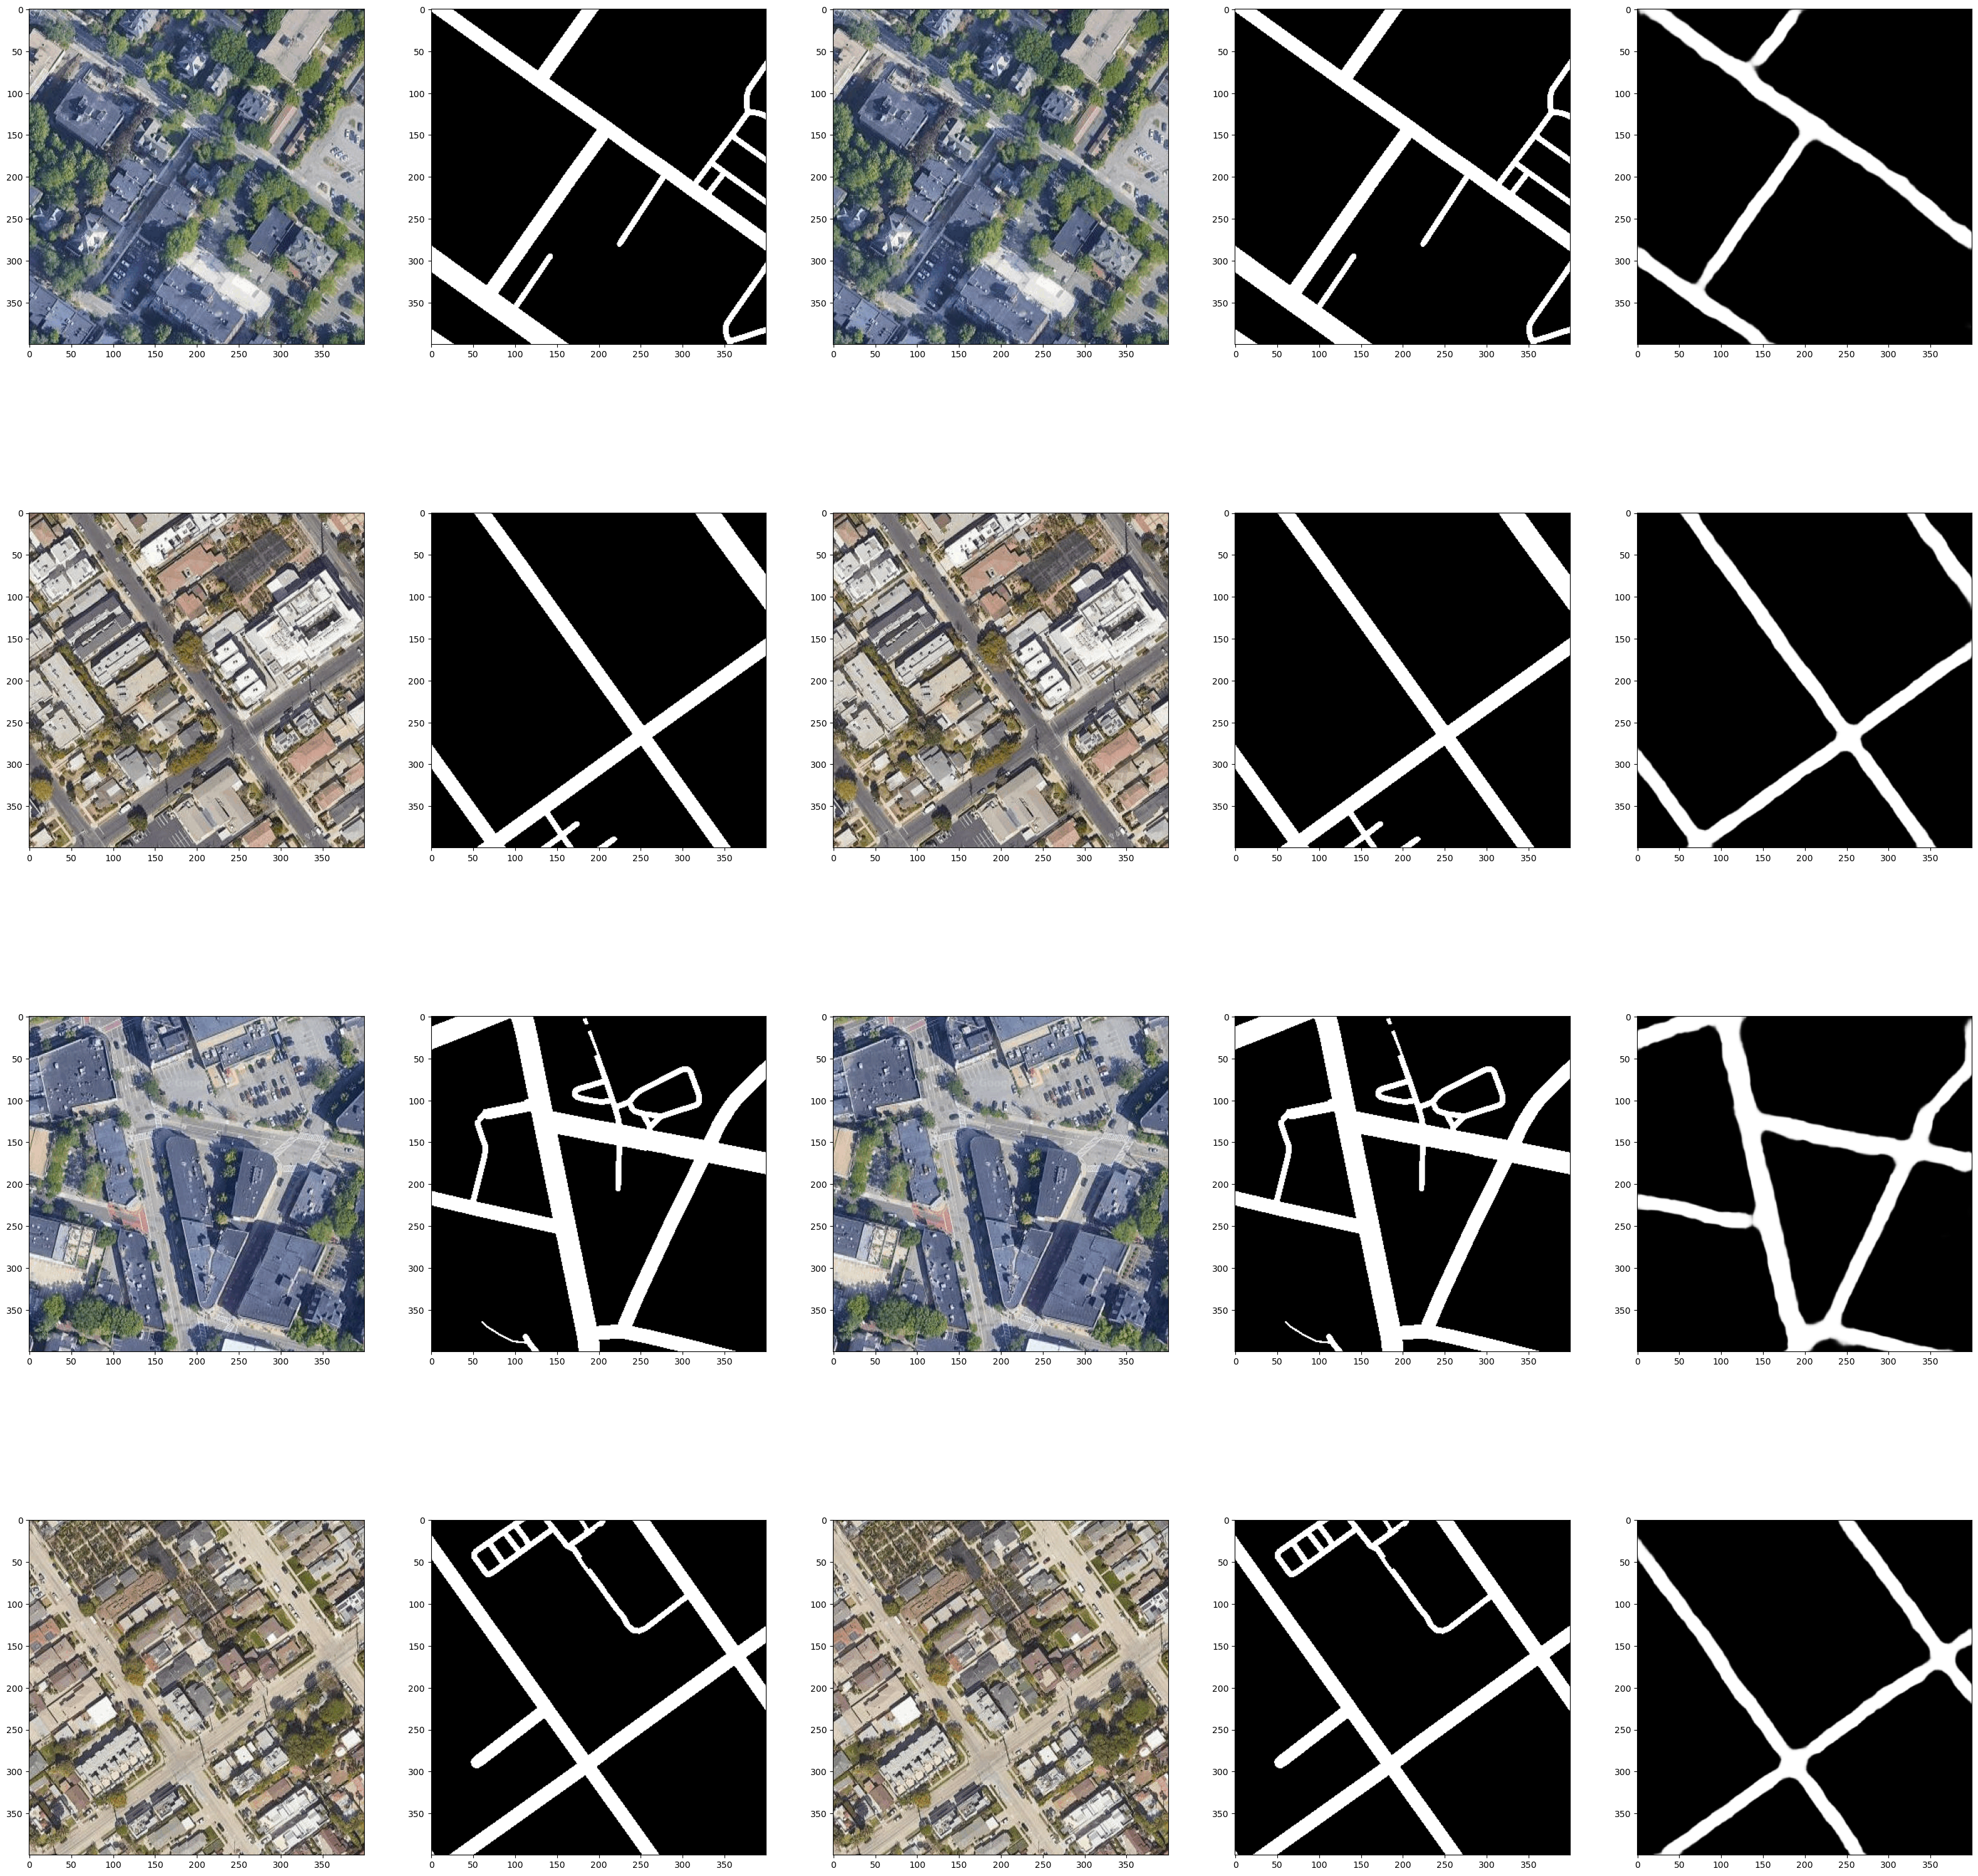

In [24]:
visualize_sample(model, actual_val_loader)

In [25]:
def save_image(data, cm, fn):
   
    sizes = np.shape(data)
    height = float(sizes[0])
    width = float(sizes[1])
     
    fig = plt.figure()
    fig.set_size_inches(width/height, 1, forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
 
    ax.imshow(data, cmap=cm)
    plt.savefig(fn, dpi = height) 
    plt.close()

In [26]:
model.eval()
with torch.no_grad():
    test_path = data_path + "ethz-cil-road-segmentation-2023/" + "test/images/"    

    files = os.listdir(test_path)
    for file in tqdm(files):
        x_orig:Image = Image.open(test_path + file).convert("RGB")
        x_orig = np.array(x_orig, dtype=np.float32)
        # print(x_orig.shape)
        x = feature_extractor(images=x_orig, return_tensors="pt").pixel_values.squeeze(0).cuda()
        # print(x.shape)
        # print(x.unsqueeze(0).shape)
        pred = model(x.unsqueeze(0)).squeeze(0)
        pred = F.sigmoid(pred).permute(1, 2, 0).cpu().numpy()
        # print(pred.shape) # (400, 400, 1)
        pred = pred.squeeze(-1)
        # print(pred.shape) # (400, 400)
        # pred = Image.fromarray((pred*255).astype(np.uint8))
        pred = pred*255

        output_dir = "/kaggle/working/pred_deeplab/"
        #make the folder
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        #pred.save(output_dir + file)
        save_image(pred, 'gray', output_dir + file)

100%|██████████| 144/144 [00:15<00:00,  9.15it/s]


In [27]:
import shutil
shutil.make_archive("/kaggle/working/pred_deeplab", 'zip', output_dir)

'/kaggle/working/pred_deeplab.zip'